<a href="https://colab.research.google.com/github/nv-hiep/Autoregressive_Models/blob/main/Autoregressive_Models_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn
import torch.utils.data
import math
import numpy as np

# Problem

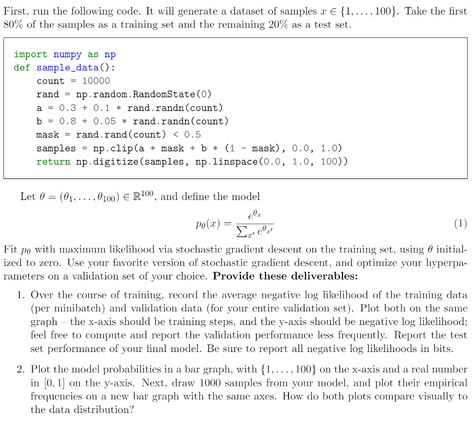

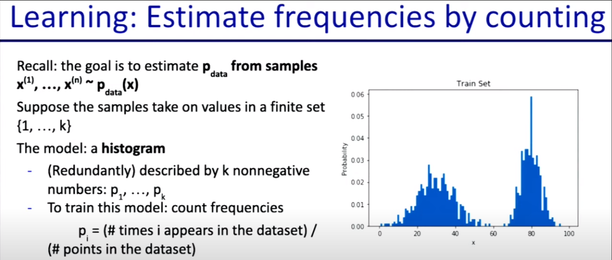

# Data

In [ ]:
seed = 1
count = 10_000

In [ ]:
rand = np.random.RandomState(seed)
rand

RandomState(MT19937) at 0x7FB516AB4E20

## First Gaussian distribution

In [ ]:
a = 0.3 + 0.1 * rand.randn(count) # mu + sigma*Normal
a

array([0.46243454, 0.23882436, 0.24718282, ..., 0.19858562, 0.29373038,
       0.15621301])

In [ ]:
mask = rand.rand(count) < 0.5
mask

array([False,  True, False, ...,  True,  True, False])

In [ ]:
(a*mask)[:20]

array([0.        , 0.23882436, 0.        , 0.19270314, 0.38654076,
       0.06984613, 0.        , 0.22387931, 0.33190391, 0.        ,
       0.        , 0.09398593, 0.26775828, 0.26159456, 0.41337694,
       0.19001087, 0.28275718, 0.        , 0.        , 0.35828152])

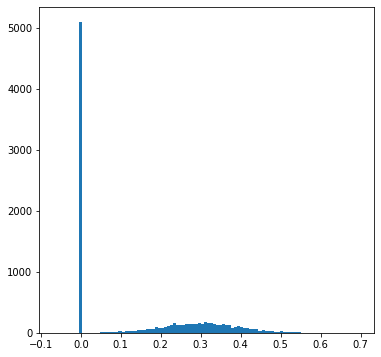

In [ ]:
plt.figure(figsize=(6,6))
plt.hist(a*mask, bins=100)
plt.show()

## Second Gaussian distribution

In [ ]:
b = 0.8 + 0.05 * rand.randn(count)

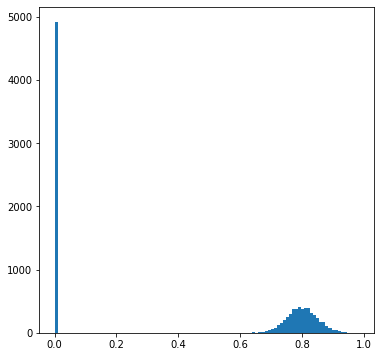

In [ ]:
plt.figure(figsize=(6,6))
plt.hist(b * (1 - mask), bins=100)
plt.show()

## Third distribution: The sum of the two Gaussian distributions

In [ ]:
samples = np.clip(a * mask + b * (1 - mask), 0.0, 1.0)

In [ ]:
np.digitize(samples, np.linspace(0.0, 1.0, 100))

array([87, 24, 83, ..., 20, 30, 81])

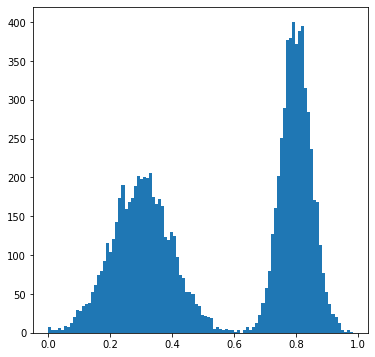

In [ ]:
plt.figure(figsize=(6,6))
plt.hist(samples, bins=100)
plt.show()

## Generate data from distributions A and B

In [ ]:
def sample_data(seed=0, count=10000):
  rand = np.random.RandomState(seed)
  a = 0.3 + 0.1 * rand.randn(count)
  b = 0.8 + 0.05 * rand.randn(count)
  mask = rand.rand(count) < 0.5
  samples = np.clip(a * mask + b * (1 - mask), 0.0, 1.0)
  
  # Return the indices of the binned data
  return np.digitize(samples, np.linspace(0.0, 1.0, 100))

In [ ]:
# Generate data: the integer numbers (they are the indices of the binned data a + b)
data = sample_data()
data

array([48, 76, 88, ..., 35, 30, 43])

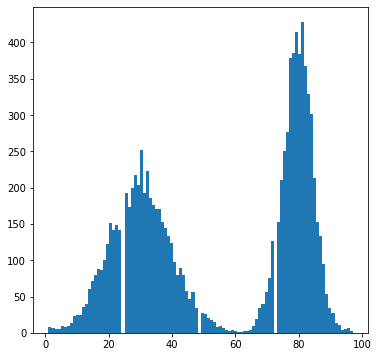

In [ ]:
plt.figure(figsize=(6,6))
plt.hist(data, bins=100)
plt.show()

### Split the samples as a training set 60%, validation set 20% and the remaining 20% as a test set.

In [ ]:
size = len(data)
training_set = data[:int(size*0.6)] 
val_set      = data[int(size*0.6):int(size*0.8)]
test_set     = data[int(size*0.8):]

PyTorch provides two data primitives: torch.utils.data.DataLoader and torch.utils.data.Dataset that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

In [ ]:
print('Training set size:', len(training_set))
print('Valid set size:', len(val_set))
print('Test set size:', len(test_set))

Training set size: 6000
Valid set size: 2000
Test set size: 2000


# Model

Let $\theta = (\theta_{1}, ..., \theta_{100}) \in \mathbb{R}^{100}$, and define the model:

$p_{\theta}(x) = \frac{e^{\theta_{x}}}{\sum_{x'}{e^{\theta_{x'}}}}$

Fit $p_{\theta}$ with maximum likelihood via stochastic gradient descent on the training set, using $\theta$ initialized to zero. Use your favorite version of stochastic gradient descent, and optimize your hyperparameters on a validation set of your choice.

In [ ]:
# Initiate the params theta
theta = torch.zeros(100, requires_grad=True)

In [ ]:
p_theta = torch.exp(theta) / torch.sum(torch.exp(theta))

In [ ]:
p_theta

tensor([0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100], grad_fn=<DivBackward0>)

Maximum likelihood (or minimum negative likelihood): Given a dataset $\mathbf{x^{(1)}, x^{(2)},..., x^{(n)}}$, find $\theta$ by solving the optimization problem:

$\arg \min\limits_{\theta} loss(\theta, \mathbf{x^{(1)}, x^{(2)},..., x^{(n)}}) = \frac{1}{n} \sum_{i=1}^{n}-log~ p_{\theta}(\mathbf{x^{(i)}})$

In [ ]:
def compute_loss(theta, x):
  # softmax
  # See the PDF file, this is the model
  p_theta = torch.exp(theta) / torch.sum(torch.exp(theta))

  #instead of having a one hot encoded vector x, just use gather instead:
  prob = torch.gather(p_theta, dim=0, index=x)

  loss = torch.sum(-torch.log2(prob))/prob.shape[0]
  return loss


Over the course of training, record the average negative log likelihood of the training data (per minibatch) and validation data (for your entire validation set). Plot both on the same graph – the x-axis should be training setps, and the y-axis should be negative log likelihood; feel free to compute and report the validation performance less frequently. Report the test set performance of your final model. Be sure to report all negative log likelihoods in bits.

# Train the model

In [ ]:
batch_size = 512
optimizer = torch.optim.Adam([theta], lr=3e-4)
epochs=1000

Our model seems to have generally learned the distribution of the data. However, it failed to capture the masked values that do not appear in the true distribution ($p(x) = 0$).

In [ ]:
'''
loss.backward() computes dloss/dx for every parameter x which has requires_grad=True. These are accumulated into x.grad for every parameter x. In pseudo-code:

x.grad += dloss/dx
optimizer.step updates the value of x using the gradient x.grad. For example, the SGD optimizer performs:
x += -lr * x.grad

optimizer.zero_grad() clears x.grad for every parameter x in the optimizer.
It’s important to call this before loss.backward(), otherwise you’ll accumulate the gradients from multiple passes.

If you have multiple losses (loss1, loss2) you can sum them and then call backwards once:

loss3 = loss1 + loss2
loss3.backward()
'''

train_iter   = torch.utils.data.DataLoader(dataset=training_set, batch_size=batch_size, shuffle=True)
val_set_iter = torch.utils.data.DataLoader(dataset=val_set, batch_size=batch_size, shuffle=True)
losses = []
val_losses = []

for epoch in range(epochs):
  train_loss = 0

  for train_batch in train_iter:
    loss = compute_loss(theta, train_batch)

    # loss.backward() computes dloss/dx for every parameter x which has requires_grad=True.
    # These are accumulated into x.grad for every parameter x. In pseudo-code: x.grad += dloss/dx
    loss.backward()

    # optimizer.step updates the value of x using the gradient x.grad.
    # For example, the SGD optimizer performs: x += -lr * x.grad
    optimizer.step()

    # optimizer.zero_grad() clears x.grad for every parameter x in the optimizer.
    # It’s important to call this before loss.backward(),
    # otherwise you’ll accumulate the gradients from multiple passes.
    # If you have multiple losses (loss1, loss2) you can sum them and then call backwards once:
    # loss3 = loss1 + loss2
    # loss3.backward()
    optimizer.zero_grad()

    losses.append(loss)

  with torch.set_grad_enabled(False):
    val_loss = compute_loss(theta,torch.from_numpy(val_set))
    val_losses.append(val_loss)

  if epoch % 100 ==0:
    print('Epoch {}: loss = {}, val_loss = {} '.format(epoch,loss,val_loss))

Epoch 0: loss = 6.6399922370910645, val_loss = 6.639645099639893 
Epoch 100: loss = 6.309025764465332, val_loss = 6.310399055480957 
Epoch 200: loss = 6.135517120361328, val_loss = 6.111696243286133 
Epoch 300: loss = 5.97560453414917, val_loss = 5.994277477264404 
Epoch 400: loss = 5.952483654022217, val_loss = 5.927621841430664 
Epoch 500: loss = 5.8838582038879395, val_loss = 5.891612529754639 
Epoch 600: loss = 5.812645435333252, val_loss = 5.872218132019043 
Epoch 700: loss = 5.889317512512207, val_loss = 5.86106538772583 
Epoch 800: loss = 5.854252815246582, val_loss = 5.8543009757995605 
Epoch 900: loss = 5.775710582733154, val_loss = 5.850216865539551 


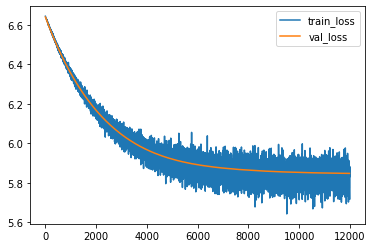

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses, label = "train_loss")
plt.plot(np.arange(0, len(losses),int(len(losses)/len(val_losses))),val_losses, label = "val_loss")
plt.legend()
plt.show()

### Losses from test dataset

In [ ]:
test_iter = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)

# Compute Test Loss
test_loss = []
for idx, test_batch in enumerate(test_iter):
  test_loss.append( compute_loss(theta, test_batch) )

print('Size of test_loss', len(test_loss))
print(test_loss)

Size of test_loss 4
[tensor(5.8366, grad_fn=<DivBackward0>), tensor(5.8660, grad_fn=<DivBackward0>), tensor(5.7909, grad_fn=<DivBackward0>), tensor(5.8019, grad_fn=<DivBackward0>)]


In [ ]:
# Show the final losses
print("Final Training Loss:", losses[-1].item())
print("Final Validation Loss:", val_losses[-1].item())
print("Final Test Loss:", test_loss[-1].item())

Final Training Loss: 5.859883785247803
Final Validation Loss: 5.847787380218506
Final Test Loss: 5.801925182342529


## Data distributions

In [ ]:
# Theta after the training
print(len(theta))
theta

100


tensor([-2.7543, -2.1674, -2.0454, -2.2917, -2.2912, -2.1624, -2.0463, -1.6498,
        -1.9339, -1.3419, -1.3411, -1.2748, -0.8470, -0.7609, -0.0845, -0.3007,
        -0.0425, -0.0418, -0.0830,  0.1966,  0.3048,  0.5502,  0.5490,  0.6499,
         0.5027,  0.7384,  0.7475,  0.8384,  0.8633,  0.8459,  1.1145,  0.8129,
         0.9441,  0.7927,  0.7287,  0.7480,  0.6684,  0.5736,  0.5382,  0.4414,
         0.5618,  0.1622, -0.2220, -0.1054, -0.0213, -0.3282, -0.7214, -0.4421,
        -0.8465, -1.0955, -0.9889, -1.4853, -1.4858, -1.7356, -2.1639, -1.8340,
        -2.0506, -2.4331, -2.4338, -2.4322, -2.7543, -2.5858, -2.5870, -2.7543,
        -2.5867, -2.1662, -1.8344, -1.4108, -0.7604, -0.7191, -0.5379, -0.0626,
         0.4278,  0.5946,  0.8868,  1.0739,  1.2877,  1.5253,  1.5476,  1.6363,
         1.5725,  1.5518,  1.4109,  1.3306,  1.2829,  0.9110,  0.6267,  0.4151,
         0.1627, -0.3554, -1.0972, -1.0420, -1.6494, -1.6493, -2.2944, -2.4320,
        -2.4316, -2.5871, -2.7543, -2.75

Plot the model probabilities in a bar graph, which $\{1, ..., 100\}$ on the x-axis and a real number in $[0, 1]$ on the y-axis. Next, draw 1000 samples from your model, and plot their empirical frequencies on a new bar graph with the same axes. How do both compare visually to the data distribution?

In [ ]:
p = torch.exp(theta)/torch.sum(torch.exp(theta))
print(len(p))
print(p)

100
tensor([0.0005, 0.0010, 0.0011, 0.0008, 0.0008, 0.0010, 0.0011, 0.0016, 0.0012,
        0.0022, 0.0022, 0.0023, 0.0036, 0.0039, 0.0077, 0.0062, 0.0080, 0.0080,
        0.0077, 0.0102, 0.0113, 0.0145, 0.0145, 0.0160, 0.0138, 0.0175, 0.0176,
        0.0193, 0.0198, 0.0195, 0.0255, 0.0188, 0.0215, 0.0185, 0.0173, 0.0177,
        0.0163, 0.0148, 0.0143, 0.0130, 0.0147, 0.0098, 0.0067, 0.0075, 0.0082,
        0.0060, 0.0041, 0.0054, 0.0036, 0.0028, 0.0031, 0.0019, 0.0019, 0.0015,
        0.0010, 0.0013, 0.0011, 0.0007, 0.0007, 0.0007, 0.0005, 0.0006, 0.0006,
        0.0005, 0.0006, 0.0010, 0.0013, 0.0020, 0.0039, 0.0041, 0.0049, 0.0078,
        0.0128, 0.0151, 0.0203, 0.0245, 0.0303, 0.0384, 0.0393, 0.0429, 0.0403,
        0.0394, 0.0343, 0.0316, 0.0301, 0.0208, 0.0156, 0.0127, 0.0098, 0.0059,
        0.0028, 0.0029, 0.0016, 0.0016, 0.0008, 0.0007, 0.0007, 0.0006, 0.0005,
        0.0005], grad_fn=<DivBackward0>)


In [ ]:
# the detach method means "I don't want gradients," and
# it is impossible to track gradients through numpy operations (after all, that is what PyTorch tensors are for!)
p = p.detach().numpy()
print(len(p))
print(p)

100
[0.00053179 0.00095641 0.00108042 0.00084459 0.00084497 0.00096118
 0.00107952 0.00160472 0.00120792 0.00218344 0.00218508 0.00233499
 0.00358164 0.00390366 0.00767759 0.00618459 0.0080071  0.00801258
 0.00768866 0.01016982 0.01133112 0.01448362 0.01446601 0.01600191
 0.01381155 0.01748275 0.01764272 0.01932025 0.01980724 0.01946589
 0.02546342 0.01883398 0.02147477 0.01845704 0.01731334 0.0176505
 0.01630007 0.01482603 0.01431039 0.0129896  0.01465197 0.00982524
 0.00669093 0.00751865 0.00817848 0.00601673 0.00406065 0.00536938
 0.00358334 0.00279338 0.00310761 0.00189179 0.00189068 0.00147288
 0.00095972 0.00133484 0.00107482 0.0007332  0.00073272 0.00073388
 0.00053179 0.0006294  0.0006286  0.00053179 0.0006288  0.00095752
 0.00133421 0.00203812 0.00390561 0.00407018 0.00487894 0.00784718
 0.01281484 0.01514019 0.02027966 0.0244509  0.03028032 0.03840223
 0.03926813 0.04290738 0.04025565 0.03943343 0.03425018 0.03160607
 0.03013543 0.02077664 0.0156343  0.01265306 0.00983075 0.0

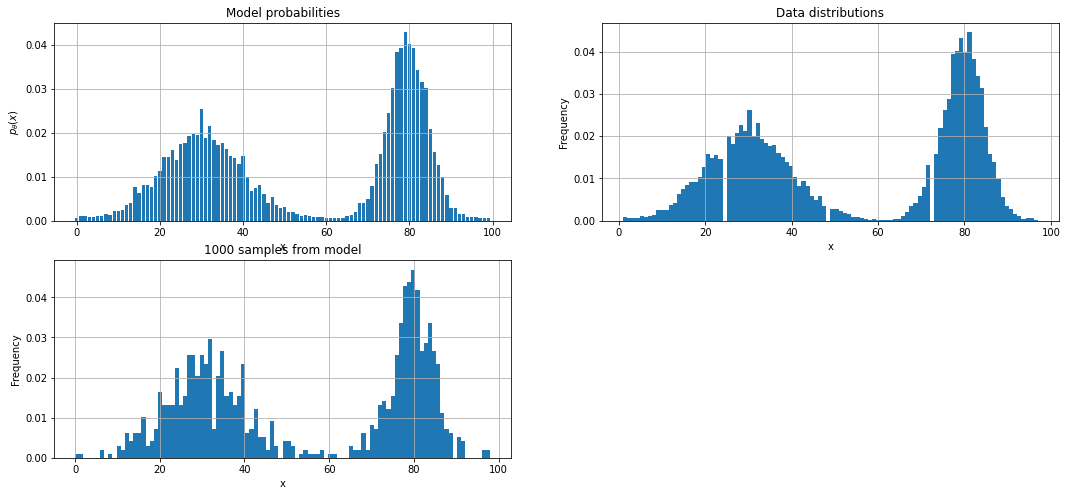

In [ ]:

# Sampling after training
plt.figure(figsize=(18, 8))
plt.subplot(221)
plt.bar(np.arange(len(p)), p)
plt.title('Model probabilities')
plt.xlabel('x')
plt.ylabel('$p_{\\theta}(x)$')
plt.grid(True)

plt.subplot(222)
plt.hist(data, bins=100, density=True)
plt.title('Data distributions')
plt.xlabel('x')
plt.ylabel('Frequency')
plt.grid(True)

plt.subplot(223)
samples = np.random.choice(np.arange(100), p=p, size=1000)
plt.hist(samples, bins=100, density=True)
plt.title('1000 samples from model')
plt.xlabel('x')
plt.ylabel('Frequency')
plt.grid(True)